In [11]:
!pip install numpy-quaternion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 3.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for numpy-quaternion: filename=numpy_quaternion-2022.4.2-cp37-cp37m-linux_x86_64.whl size=158427 sha256=d5792b99363bd5886a04aeb720d28104d2315813d196fb400e80c2c1b506a107
  Stored in directory: /root/.cache/pip/wheels/ce/dc/f3/1b4a5e49b5590eec6fe35cc44fce61b37f599dd67468472075
Successfully built numpy-quaternion


In [12]:
from mpl_toolkits import mplot3d
#import bagpy
#from bagpy import bagreader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.signal.filter_design import butter
from scipy import signal

#a=bagreader('/imu_1.bag')
#e = a.message_by_topic('/imu')

imucsv = pd.read_csv('/content/drive/MyDrive/data_driving/imu.csv')

mag_x = imucsv['MagField.magnetic_field.x']
mag_y = imucsv['MagField.magnetic_field.y']
mag_z = imucsv['MagField.magnetic_field.z']

# plt.grid()
# plt.scatter(mag_x, mag_y, marker="o",c='w',edgecolors='r')
# mycircle = plt.Circle((0.1,-0.13),0.2, fill = False)
# plt.gca().add_patch(mycircle) 
# plt.gca().set_aspect("equal")
# plt.show()

In [13]:
#HardIron _correction
x_max = max(mag_x)
y_max = max(mag_y)
x_min = min(mag_x)
y_min = min(mag_y)

print(x_max,y_max, x_min, y_min )

alpha = (x_max+x_min)/2
beta = (y_max+y_min)/2

hiron_x = []
hiron_x.extend((mag_x-alpha))
hiron_y = []
hiron_y.extend((mag_y-beta))

# plt.grid()
# plt.scatter(hiron_x, hiron_y, marker=".",c='b',edgecolors='r')
# mycircle = plt.Circle((0.0,0.0),0.2, fill = False)
# plt.gca().add_patch(mycircle) 
# plt.gca().set_aspect("equal")
# plt.title("Hard_iron corrected plot of MagField(x vs y) ")
# plt.xlabel("Hiron_x")
# plt.ylabel("Hiron_y")
# plt.show()

0.3589 0.1784 -0.3791 -0.4449


In [14]:
#SOFT-IRON

x1 = float(hiron_x[2000])
y1 = float(hiron_y[2000])
print(x1,y1)

arry_hiron_x = np.array(hiron_x)
arry_hiron_y = np.array(hiron_y)

#b1 = np.concatenate((arry_hiron_x, arry_hiron_y))

r = math.sqrt((x1**2) + (y1**2))
theta = np.arcsin(y1/r)
theta_d = (theta*(180/np.pi))


#matrix generation
R = np.array([[np.cos(theta), np.sin(theta)],
     [-np.sin(theta), np.cos(theta)]])
b = np.array([[hiron_x, hiron_y]]) 
v1 = np.matmul(R, b)


# plt.grid()
# plt.scatter(v1[:,0], v1[:,1], marker="o",c='w',edgecolors='g')
# mycircle2 = plt.Circle((0,0),0.2, fill = False)
# plt.gca().add_patch(mycircle2) 
# plt.gca().set_aspect("equal") 
# plt.show()  


#scale factor

sigma = 0.15/0.2

print(f"sigma={sigma}")

# correction method

scale = np.array([[1, 0],
                 [0, sigma]])
correct_mag_x1 = scale @ v1

theta1 = -theta

R_cal = np.array([[np.cos(theta1), np.sin(theta1)],
      [-np.sin(theta1), np.cos(theta1)]])
v_cal = np.matmul(R_cal, correct_mag_x1)

# plt.figure(figsize = (12,8))
# plt.grid()
# plt.scatter(v_cal[:,0], v_cal[:,1], marker=".",c='r',edgecolors='b')
# mycircle4 = plt.Circle((0,0),0.16, fill = False)
# plt.gca().add_patch(mycircle4) 
# plt.gca().set_aspect("equal") 

# plt.scatter(mag_x, mag_y, marker="o",c='w',edgecolors='r')
# mycircle3 = plt.Circle((0.1,-0.15),0.2, fill = False)
# plt.gca().add_patch(mycircle3) 
# plt.gca().set_aspect("equal") 
# plt.show()  


0.2859 -0.26575000000000004
sigma=0.7499999999999999


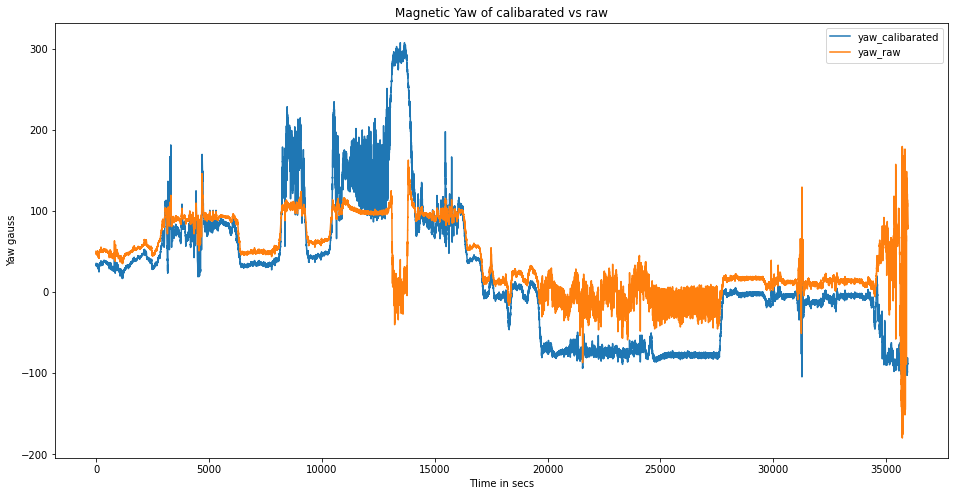

In [15]:
x = imucsv['IMU.orientation.x']
y = imucsv['IMU.orientation.y'] 
z = imucsv['IMU.orientation.z']
w = imucsv['IMU.orientation.w']
time_secs = imucsv['Header.stamp.secs']
time_nsecs = imucsv['Header.stamp.nsecs']
time = imucsv['Time']

def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = np.arctan2(t0, t1)
        
        t2 = +2.0 * (w * y - z * x)
        pitch_y = np.arcsin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = np.arctan2(t3, t4)
        return roll_x, pitch_y, yaw_z # in radian

roll_x, pitch_y, yaw_z = euler_from_quaternion(x, y, z, w)

roll = roll_x    # roll = phi

pitch = pitch_y   #pitch = theta

yaw = yaw_z      #yaw = sye

m_x = v_cal[:, 0]
m_y = v_cal[:, 1]
m_z1 = imucsv['MagField.magnetic_field.z']
m_z2 = m_z1.to_numpy()
m_z = np.reshape(m_z2, (1, 35952))
#YAAW calculation with calibarated data

xa = m_z*list(np.sin(roll))
xb = m_y*list(np.cos(roll))
X = xa - xb
ya = m_x*list(np.cos(pitch))
yb = m_y*list(np.sin(pitch)*np.sin(roll))
yc = m_z*list(np.sin(pitch)*np.cos(roll))

Y = ya+yb+yc
yaw_cal = np.arctan2(X, Y)
yawcal1 = np.unwrap(yaw_cal)
yaw_cmax = max(yawcal1)
yaw_cal_f = pd.Series(yaw_cmax)
yaw_cal_f = yaw_cal_f*(180/np.pi)

#YAW calculation with non_calibarated data
xra = mag_z*list(np.sin(roll))
xrb = mag_y*list(np.cos(roll))

X_raw = xra - xrb


yra = mag_x*list(np.cos(pitch))
yrb = mag_y*list(np.sin(pitch)*np.sin(roll))
yrc = mag_z*list(np.sin(pitch)*np.cos(roll))

Y_raw = yra+yrb+yrc

yaw_raw_cal = np.arctan2(X_raw, Y_raw)
yawccaa = np.unwrap(yaw_raw_cal)
yaw_cal_raw_f = pd.Series(yaw_raw_cal)
yaw_cal_raw_f = yaw_cal_raw_f*(180/np.pi)
plt.figure(figsize = (16,8))
plt.plot(yaw_cal_f, label = 'yaw_calibarated')
plt.plot(yaw_cal_raw_f, label = 'yaw_raw')
plt.legend(loc = "upper right")
plt.title('Magnetic Yaw of calibarated vs raw')
plt.xlabel('TIime in secs')
plt.ylabel('Yaw gauss')
plt.show()

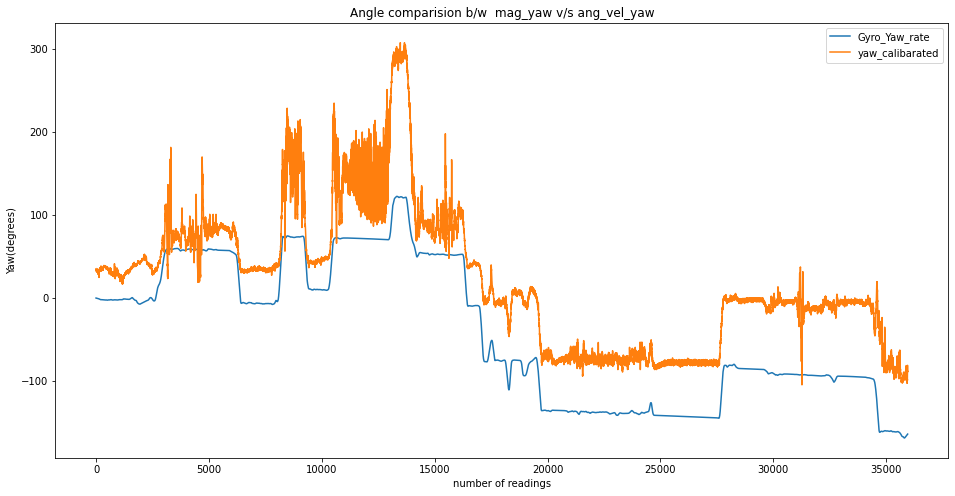

In [16]:
import scipy.integrate as integrate

time_secs = imucsv['Header.stamp.secs']
time_nsecs = np.double(imucsv['Header.stamp.nsecs'])
time_nsecs = time_nsecs/1000000000
timex = np.double(time_secs) + time_nsecs
# times = time - time[1]

gyro_int = integrate.cumtrapz(imucsv['IMU.angular_velocity.z'], initial=0)
# yaw_intigral = pd.Series(f_int)
gyro_int_wrap= np.unwrap(gyro_int)
plt.figure(figsize = (16,8))
plt.plot(gyro_int, label = 'Gyro_Yaw_rate')   
plt.plot(yaw_cal_f, label = 'yaw_calibarated')
# plt.plot(yaw_cal_raw_f, label = 'yaw_raw') 
plt.legend()
plt.title('Angle comparision b/w  mag_yaw v/s ang_vel_yaw')
plt.xlabel('number of readings')    
plt.ylabel('Yaw(rads)')                                                                                                               
plt.show()

**Lowpass and High Pass Filters**


[ 34.23479203  34.21580525  34.19688281 ... -95.00119564 -95.00119951
 -95.00120256]
6.681403628388998


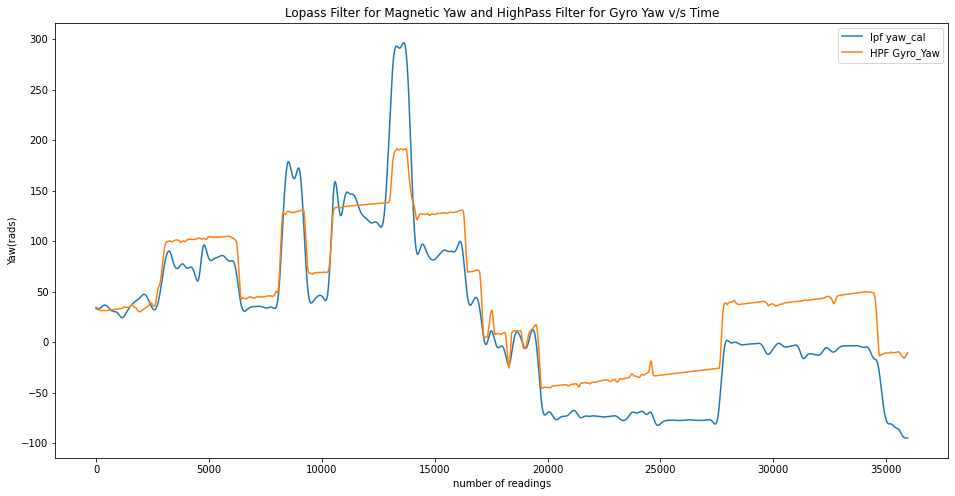

In [87]:
lpf = signal.filtfilt(*butter(3, 0.08, 'low', fs = 40), yaw_cal_f)

hpf = signal.filtfilt(*butter(3, 0.0001, 'high', fs = 40), gyro_int_wrap)
print(lpf)
print(lpf[1]/10+hpf[1]/10)
plt.figure(figsize = (16,8))
plt.plot(lpf, label='lpf yaw_cal')
plt.legend(loc = "upper right")
plt.xlabel('TIime in secs')
plt.ylabel('Yaw')
plt.plot(hpf, label = 'HPF Gyro_Yaw')
plt.legend(loc = "upper right")
plt.title('Lopass Filter for Magnetic Yaw and HighPass Filter for Gyro Yaw v/s Time')
plt.xlabel('number of readings')    
plt.ylabel('Yaw(rads)')  
plt.show()

Complimentary Filter

[0.]
[  0.           9.77638498  17.1036869  ... -96.62373988 -96.61553442
 -96.6073468 ]


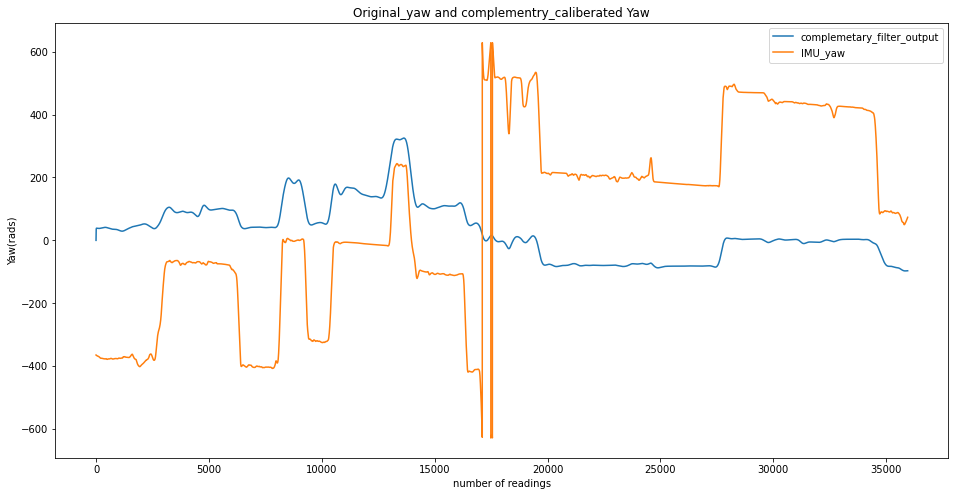

In [102]:
from quaternion import quaternion, from_rotation_vector, rotate_vectors
alpha = 0.75
omega = imucsv['IMU.angular_velocity.z']
# print(len(hpf))
# print(len(lpf))
yaw_filtered=[]
yaw_filtered=np.append(yaw_filtered,0)
print(yaw_filtered)
# for i in range(35951):
#   yaw_filtered = np.append(yaw_filtered, alpha*(yaw_filtered[i]+hpf[i])+ (1-alpha)*(lpf[i]))
for i in range(35951):
  j = i+1
  yaw_filtered = np.append(yaw_filtered, alpha*(yaw_filtered[i] + hpf[j]*0.05) + ((1-alpha)*lpf[j]))
  
print(yaw_filtered)
plt.figure(figsize = (16,8))
plt.plot(yaw_filtered, label='complemetary_filter_output')
plt.plot(yaw_z*200, label = 'IMU_yaw')
plt.legend(loc = "upper right")
plt.xlabel('number of readings')    
plt.ylabel('Yaw(rads)')  
plt.title('Original_yaw and complementry_caliberated Yaw')
plt.show()
# plt.plot(yaw_z, label = 'IMU_yaw')
# plt.show()
# plt.plot(yaw_filtered/10000, label='complimetary_filter_output')
# plt.show()

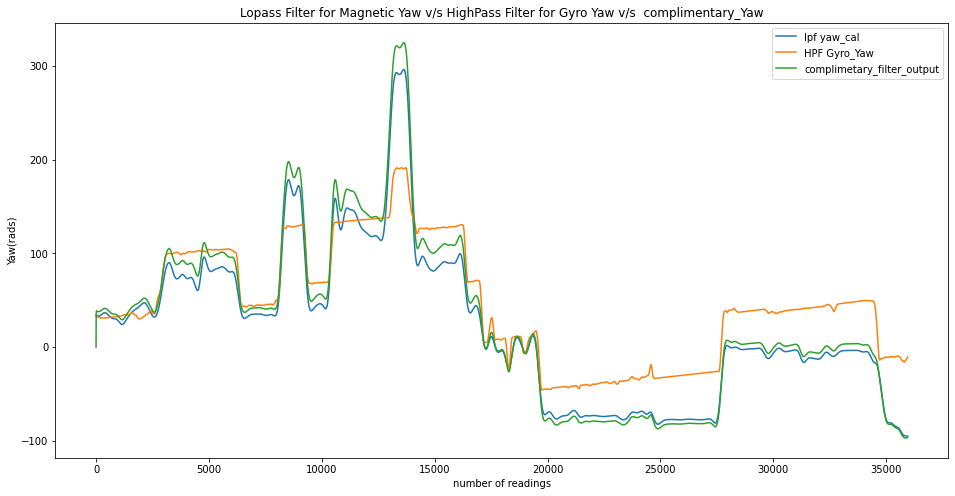

In [93]:
plt.figure(figsize = (16,8))
plt.plot(lpf, label='lpf yaw_cal')
plt.legend(loc = "upper right")
plt.plot(hpf, label = 'HPF Gyro_Yaw')
plt.plot(yaw_filtered, label='complimetary_filter_output')
#plt.plot(yaw_z, label = 'IMU_yaw')
plt.legend(loc = "upper right")
plt.xlabel('number of readings')    
plt.ylabel('Yaw(rads)')  
plt.title('Lopass Filter for Magnetic Yaw v/s HighPass Filter for Gyro Yaw v/s  complimentary_Yaw')
plt.show()

**IMU Velocity**

In [ ]:
import numpy as np
from numpy import diff 
import sympy as sym

raw_val = imucsv['IMU.linear_acceleration.x']
x = np.mean(raw_val)
leniaraccl = raw_val-x

diff = []
for i in range(35951):
  diff = np.append(diff, (leniaraccl[i+1] - leniaraccl[i])/(0.025))
print(leniaraccl)


final = (leniaraccl[1:] - diff)       #to remove jerk

Forward_velocity_adjusted = integrate.cumtrapz(final, initial=0)
Forward_velocity_adjusted[Forward_velocity_adjusted<0] = 0
Forward_velocity_raw = integrate.cumtrapz(leniaraccl, initial=0)
print(Forward_velocity_adjusted)
plt.figure(figsize = (15,8))
plt.plot(Forward_velocity_adjusted)
# # plt.plot(Forward_velocity_raw)
plt.show()
# # plt.plot(diff/100)
# plt.show()
# plt.plot(jerk_cal)
# plt.show()
# # plt.plot(final/100)


**GPS Velocity**


In [ ]:
gpscsv = pd.read_csv('/content/drive/MyDrive/data_driving/gps.csv')
time=gpscsv['Header.stamp.secs']

Ue = gpscsv['UTM_easting']
Un = gpscsv['UTM_northing']

dist=[]
vel=[]
for i in range(898):
  dist = np.append(dist,math.sqrt(((Un[i+1]-Un[i])**2)+(Ue[i+1]-Ue[i])**2))

gps_vel=dist/time[1:]
plt.figure(figsize = (15,8))
plt.plot(time[1:], gps_vel/10)
plt.show()

**plot b/w IMU vel and gps vel.**

Text(0, 0.5, 'vel(m/s)')

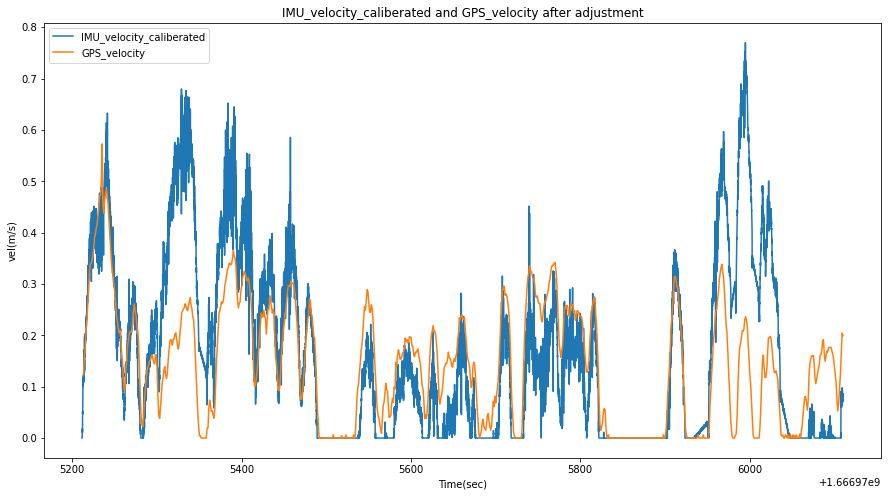

In [97]:
plt.figure(figsize = (15,8))
time_gp = gpscsv['Time']
plt.plot(timex[1:], Forward_velocity_adjusted/1000, label = 'IMU_velocity_caliberated')
plt.plot(time_gp[1:], gps_vel*2000, label = 'GPS_velocity')
plt.legend()
plt.title('IMU_velocity_caliberated and GPS_velocity after adjustment')
plt.xlabel('Time(sec)')    
plt.ylabel('vel(m/s)')  


**Plot b/w raw forward velocity from imu to gps velocity**

Text(0, 0.5, 'vel(m/s)')

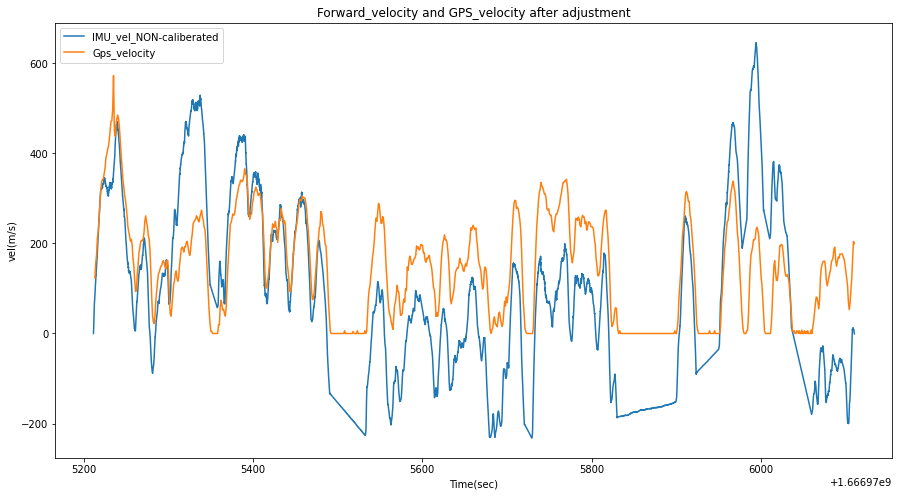

In [95]:
plt.figure(figsize = (15,8))
time_gp = gpscsv['Time']

plt.plot(timex, Forward_velocity_raw, label='IMU_velocity_NON-caliberated')
plt.plot(time_gp[1:], gps_vel*2000000, label="GPS_velocity")
plt.legend()
plt.title('Forward_velocity and GPS_velocity after adjustment')
plt.xlabel('Time(sec)')    
plt.ylabel('vel(m/s)')

**Displacement From Velocity**

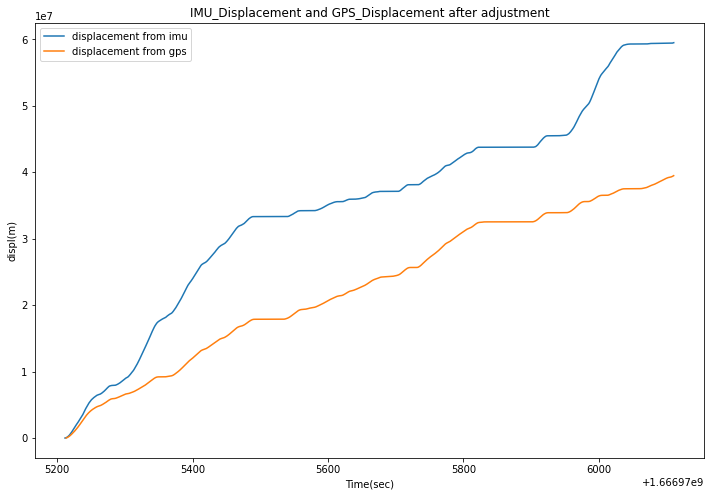

In [61]:
disp_x = integrate.cumtrapz(Forward_velocity_adjusted, initial=0)

int_gps_vel = integrate.cumtrapz(dist, initial=0)


plt.figure(figsize = (12,8))
plt.plot(timex[1:],disp_x*10, label = 'displacement from imu')
plt.plot(time_gp[1:],int_gps_vel*10000, label = 'displacement from gps')
plt.legend()
plt.title('IMU_Displacement and GPS_Displacement after adjustment')
plt.xlabel('Time(sec)')    
plt.ylabel('displ(m)')
plt.show()


std259.47130477053736


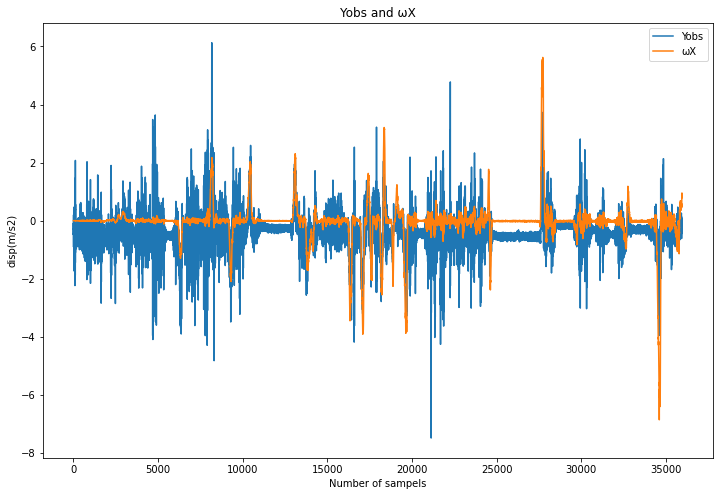

In [105]:
accex = imucsv['IMU.linear_acceleration.x']
timeimu = imucsv['Header.stamp.secs']+imucsv['Header.stamp.nsecs']*10e-9
print(f"std{np.std(timeimu)}")
x2dot = accex
x1dot = integrate.cumtrapz(x2dot)

angz = imucsv['IMU.angular_velocity.z']

y2dot = angz[1:]*x1dot

t = imucsv['Header.stamp.secs']

Y_observed = imucsv['IMU.linear_acceleration.y']

plt.figure(figsize = (12,8))
plt.plot(Y_observed, label='Yobs')
plt.plot(y2dot/1000, label ='ωX')
plt.legend()
plt.title('Yobs and ωX')
plt.xlabel('Number of sampels')    
plt.ylabel('disp(m/s2)')
plt.show()
 

35952 35951
[-0.00000000e+00 -0.00000000e+00 -1.56017169e+00 ... -7.39113945e+06
 -7.39162275e+06 -7.39210638e+06]


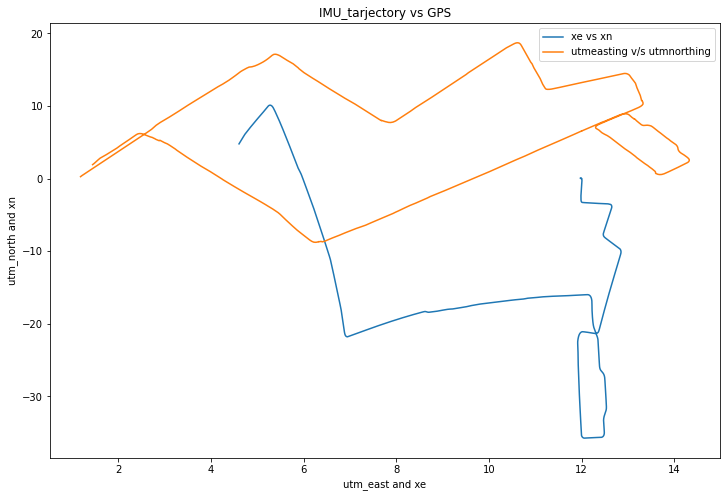

In [106]:
from scipy.optimize.minpack import fsolve
fv = np.unwrap(Forward_velocity_adjusted)
print(len(yaw_filtered), len(fv))
mgh = imucsv['MagField.magnetic_field.x']
utmeast = gpscsv['UTM_easting']
utmnorth = gpscsv['UTM_northing']
mgh1 = yaw_z
# rotation = 
rot = (-108*np.pi/180)

unit1 = np.cos(mgh1[1:]+rot)*fv
unit2 = -np.sin(mgh1[1:]+rot)*fv
unit3 = np.cos(mgh1[1:]+rot)*fv
unit4 = np.sin(mgh1[1:]+rot)*fv
rads = (180/np.pi)
ve = unit1+unit2
vn = unit3+unit4

# ve = np.unwrap(ve)
# vn = np.unwrap(vn)

xe=integrate.cumtrapz(ve)
xn=integrate.cumtrapz(vn)
# xe1=np.unwrap(np.unwrap(xe))
# xn1=np.unwrap(np.unwrap(xn))

# plt.plot(xe1, xn1)
print(xe)
plt.figure(figsize = (12,8))
plt.plot(((((xe/(10**6))/2))+6)*2,-xn/(10**5), label ='xe vs xn')
plt.plot(((utmeast/1000)-328)*10, ((((utmnorth/(4.69**7))*100)-9396)*20), label = 'utmeasting v/s utmnorthing')
plt.legend()
plt.title('IMU_tarjectory vs GPS')
plt.xlabel('utm_east and xe')
plt.ylabel('utm_north and xn')
plt.show()

